## 1. Import Libraries

Import essential libraries for graph analysis, visualization, and community detection.
import pandas as pd

In [41]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

## 2.  Load the CSV Data

Load the node and edge data from CSV files and organize it for graph creation.

In [42]:
def load_data():
   
    # Load nodes (Actors data)
    nodes_df = pd.read_csv("Actors_Dataset.csv")  # Replace with your CSV file path
    nodes = {
        row["id"]: {"name": row["name"], "CGPA": row["CGPA"], "hub": row["hub"], "hometown": row["hometown"]}
        for _, row in nodes_df.iterrows()
    }

    # Load edges (Edges data)
    edges_df = pd.read_csv("Edges_Dataset.csv")  # Replace with your CSV file path
    layers = {}
    for layer, group in edges_df.groupby("Layer"):
        layers[layer] = list(zip(group["Node 1"], group["Node 2"]))

    return nodes, layers

## 3. Create the Graph

Build a graph with nodes and interlayer connections based on the data.

In [43]:
def create_interlayer_graph(nodes, layers):
   
    G = nx.Graph()
    
    # Add nodes with attributes
    for node_id, attrs in nodes.items():
        G.add_node(node_id, **attrs)
    
    # Add edges from each layer
    for layer_name, edges in layers.items():
        for u, v in edges:
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=1.0, layer=layer_name)
            else:
                G[u][v]['weight'] += 1.0
    
    return G

## 4. Detect Communities

Use the Louvain algorithm to detect communities in the graph.

In [44]:
def detect_communities(G):
    
    partition = community_louvain.best_partition(G)
    communities = {comm_id: [] for comm_id in set(partition.values())}
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    return partition, communities

## 5. Calculate Community Metrics

Compute modularity, density, clustering coefficient, and other metrics for each community.

In [45]:
def calculate_community_metrics(G, communities):
    
    metrics = []
    
    # Convert partition into a list of sets of nodes for modularity
    community_sets = [set(nodes) for nodes in communities.values()]
    
    for comm_id, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        
        # Calculate additional metrics
        modularity = nx.algorithms.community.quality.modularity(G, community_sets)
        avg_path_length = nx.average_shortest_path_length(subgraph) if nx.is_connected(subgraph) else None
        diameter = nx.diameter(subgraph) if nx.is_connected(subgraph) else None
        edge_count = subgraph.size()
        
        # Calculate basic metrics
        density = nx.density(subgraph)
        avg_clustering_coefficient = nx.average_clustering(subgraph)
        
        metrics.append({
            'community_id': comm_id,
            'num_nodes': len(nodes),
            'density': density,
            'avg_clustering_coefficient': avg_clustering_coefficient,
            'modularity': modularity,
            'avg_path_length': avg_path_length,
            'diameter': diameter,
            'edge_count': edge_count
        })
    
    return pd.DataFrame(metrics)

## 6. Visualise Community Metrics

Plot graphs of size, density, modularity, and average path length for top communities.

In [46]:
def plot_community_metrics(metrics_df, top_n=10):

    metrics_df = metrics_df.sort_values(by='num_nodes', ascending=False).head(top_n)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Community size
    metrics_df.plot(kind='bar', x='community_id', y='num_nodes', ax=axes[0, 0])
    axes[0, 0].set_title('Community Size (Top Communities)')
    axes[0, 0].set_xlabel('Community ID')
    axes[0, 0].set_ylabel('Number of Nodes')
    
    # Community density
    metrics_df.plot(kind='bar', x='community_id', y='density', ax=axes[0, 1])
    axes[0, 1].set_title('Community Density (Top Communities)')
    axes[0, 1].set_xlabel('Community ID')
    axes[0, 1].set_ylabel('Density')
    
    # Modularity
    metrics_df.plot(kind='bar', x='community_id', y='modularity', ax=axes[1, 0])
    axes[1, 0].set_title('Community Modularity (Top Communities)')
    axes[1, 0].set_xlabel('Community ID')
    axes[1, 0].set_ylabel('Modularity')
    
    # Average Path Length
    metrics_df.plot(kind='bar', x='community_id', y='avg_path_length', ax=axes[1, 1])
    axes[1, 1].set_title('Community Avg Path Length (Top Communities)')
    axes[1, 1].set_xlabel('Community ID')
    axes[1, 1].set_ylabel('Average Path Length')
    
    plt.tight_layout()
    plt.show()

## 7. Visualize Communities on the Graph

Display the network graph with nodes colored based on their communities.

In [47]:

def plot_communities(G, partition):
    
    plt.figure(figsize=(16, 12))
    
    # Prepare node colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(set(partition.values()))))
    node_colors = [colors[partition[node]] for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, 
            node_color=node_colors, 
            with_labels=False, 
            node_size=300, 
            alpha=0.6)  # Reduced opacity for clarity
    
    plt.title("Louvain Community Detection Visualization")
    plt.tight_layout()
    plt.show()

## 8. Create Heatmap of Community Composition

 Generate a heatmap showing the distribution of communities by hometown.

In [48]:
def community_composition_heatmap(partition, nodes, top_n=5):
    
    # Count the number of nodes in each community
    community_sizes = {}
    for node in partition:
        community = partition[node]
        community_sizes[community] = community_sizes.get(community, 0) + 1

    # Sort communities by size and get the top N
    top_communities = sorted(community_sizes.items(), key=lambda item: item[1], reverse=True)[:top_n]
    top_community_ids = [community for community, _ in top_communities]

    # Prepare a DataFrame for heatmap
    composition_data = pd.DataFrame(0, 
                                    index=[f"Community {c}" for c in top_community_ids], 
                                    columns=pd.unique([node["hometown"] for node in nodes.values()]))

    # Fill composition data
    for node_id, community in partition.items():
        if community in top_community_ids:
            hometown = nodes[node_id]["hometown"]
            composition_data.loc[f"Community {community}", hometown] += 1

    # Plot the heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(composition_data.T, cmap="YlOrRd", annot=True, fmt="d", cbar=True, xticklabels=True, yticklabels=True)
    plt.title(f"Community Composition by Hometown (Top {top_n} Communities)")
    plt.xlabel("Communities")
    plt.ylabel("Hometowns")
    plt.tight_layout()
    plt.show()

## 9. Main Workflow

Execute the workflow: load data, create graph, detect communities, and visualize results.

The non-singleton detected communities are:
Community 0: [7, 10, 18, 22, 25, 30, 33, 36, 39, 42, 43, 44]
Community 1: [1, 2, 8, 13, 14, 15, 20, 21, 27, 29, 35, 38]
Community 2: [3, 4, 6, 17, 28, 40, 41, 47]
Community 3: [5, 12, 19, 45, 60]
Community 5: [9, 37]
Community 6: [11, 32]
Community 8: [23, 50, 52, 62, 66, 67, 73, 77, 90]
Community 10: [26, 46]
Community 11: [31, 48, 56, 63, 65, 80, 81, 92, 93, 104, 106, 112, 115, 123, 126]
Community 12: [34, 49]
Community 13: [51, 53, 54, 55, 61, 64, 70, 74, 78, 79, 88, 94, 95]
Community 14: [57, 68, 72, 75, 85, 89, 111, 122, 140]
Community 21: [83, 87, 96, 97, 101, 103, 107, 109, 116, 118, 120, 125]
Community 23: [86, 100]
Community 24: [91, 102, 108, 110, 113, 130]
Community 40: [135, 150]
Community 51: [147, 160]
Community 61: [158, 170]
Community 76: [175, 180]
Community 90: [190, 200]


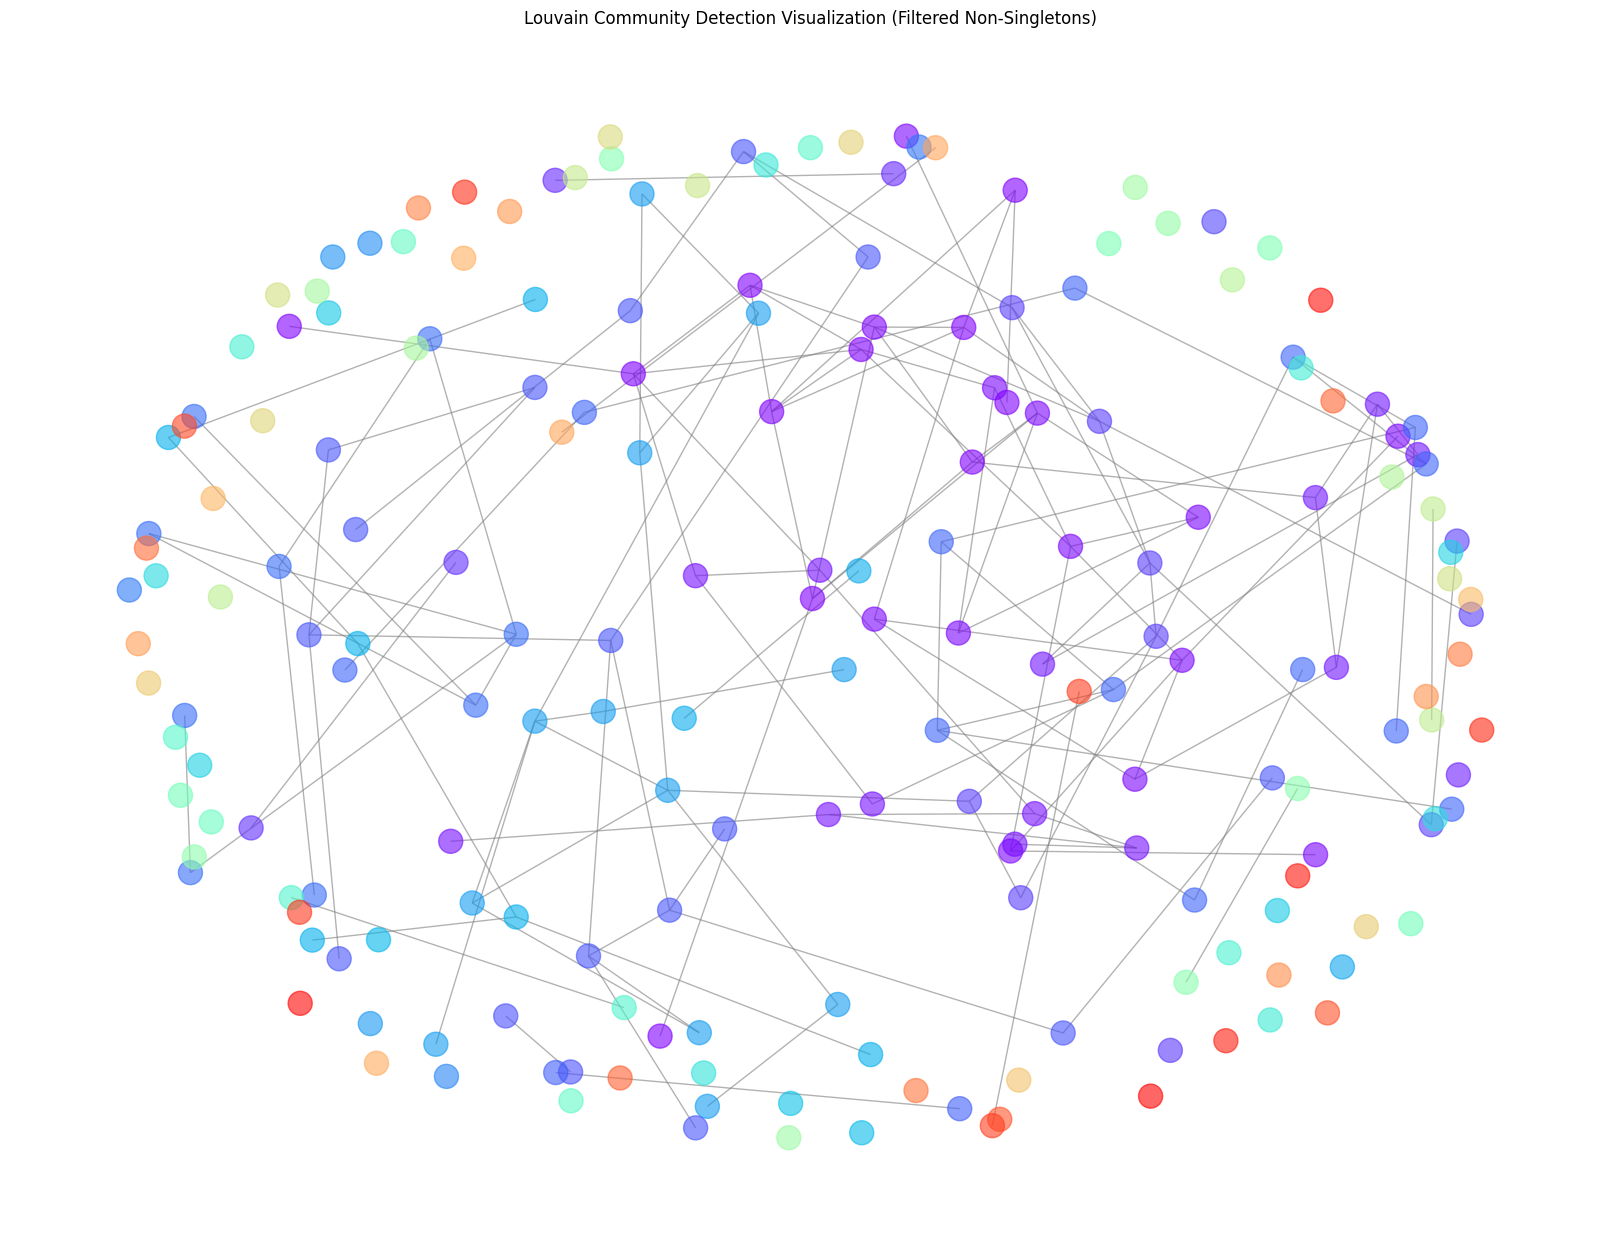

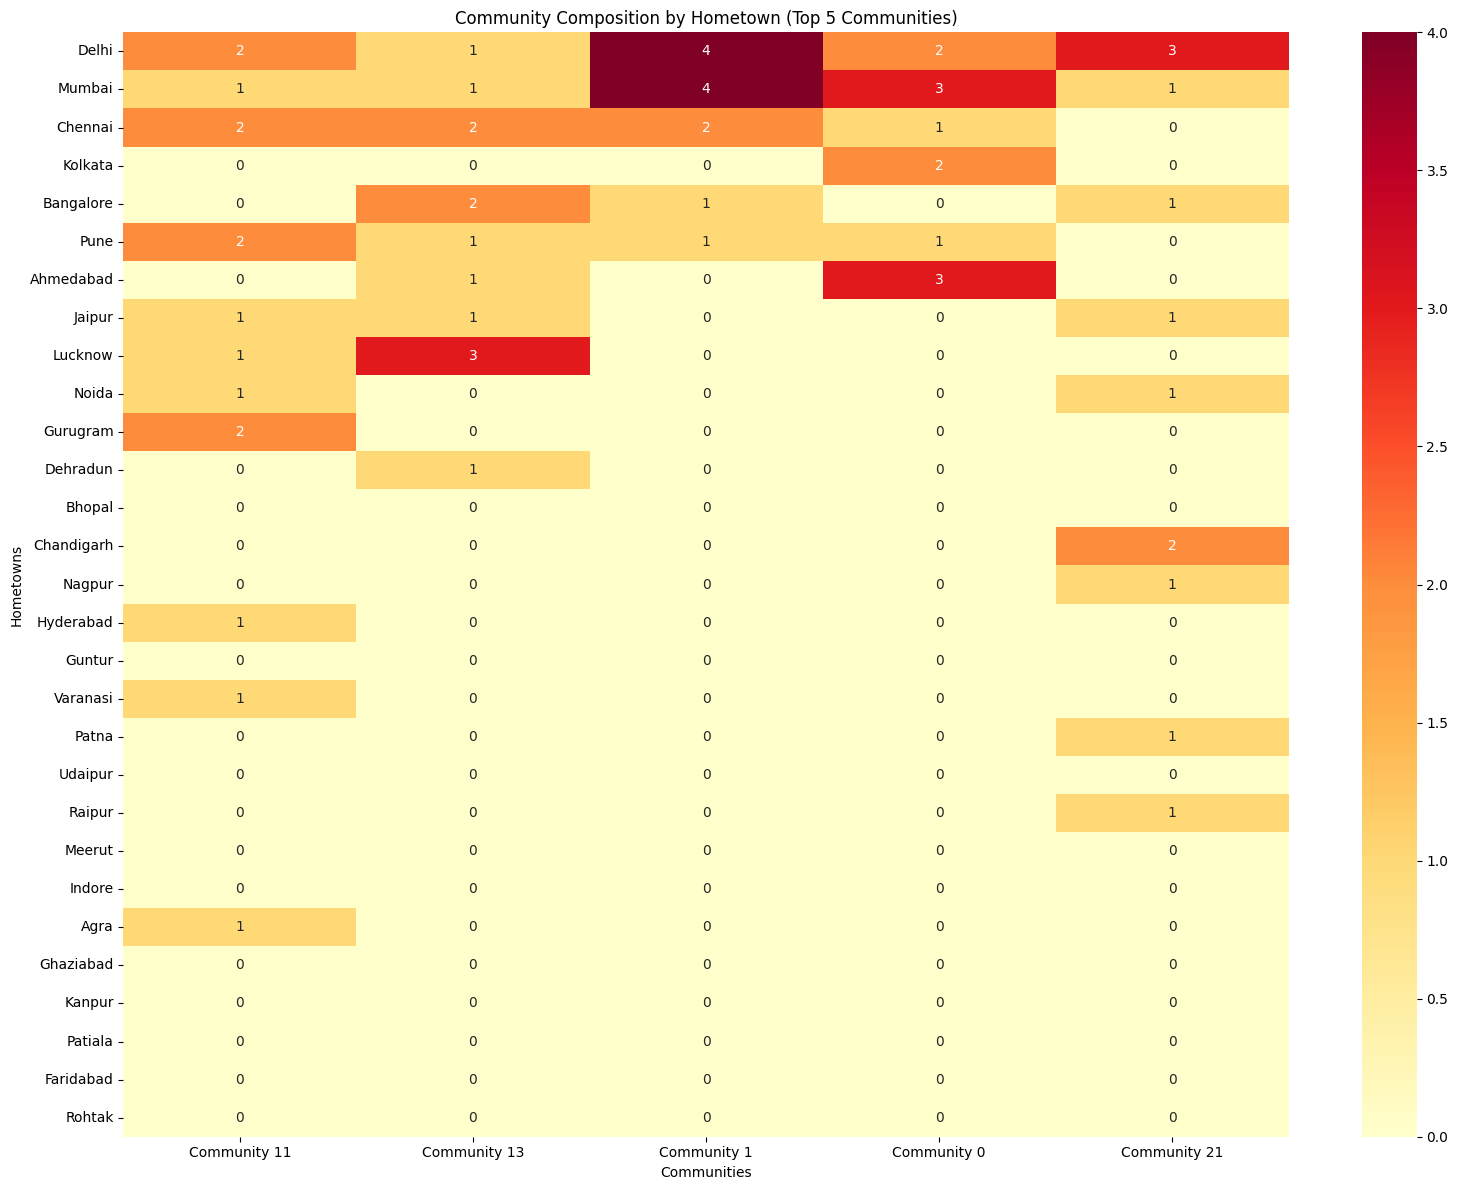


Community Metrics:
  community_id  num_nodes  density  avg_clustering_coefficient  modularity  avg_path_length  diameter  edge_count
            0         12 0.257576                    0.294444    0.780068         2.318182         5          17
            1         12 0.227273                    0.308333    0.780068         2.515152         5          15
            2          8 0.285714                    0.125000    0.780068         2.428571         5           8
            3          5 0.500000                    0.466667    0.780068         1.700000         3           5
            5          2 1.000000                    0.000000    0.780068         1.000000         1           1
            6          2 1.000000                    0.000000    0.780068         1.000000         1           1
            8          9 0.277778                    0.425926    0.780068         2.305556         4          10
           10          2 1.000000                    0.000000    0.780068  

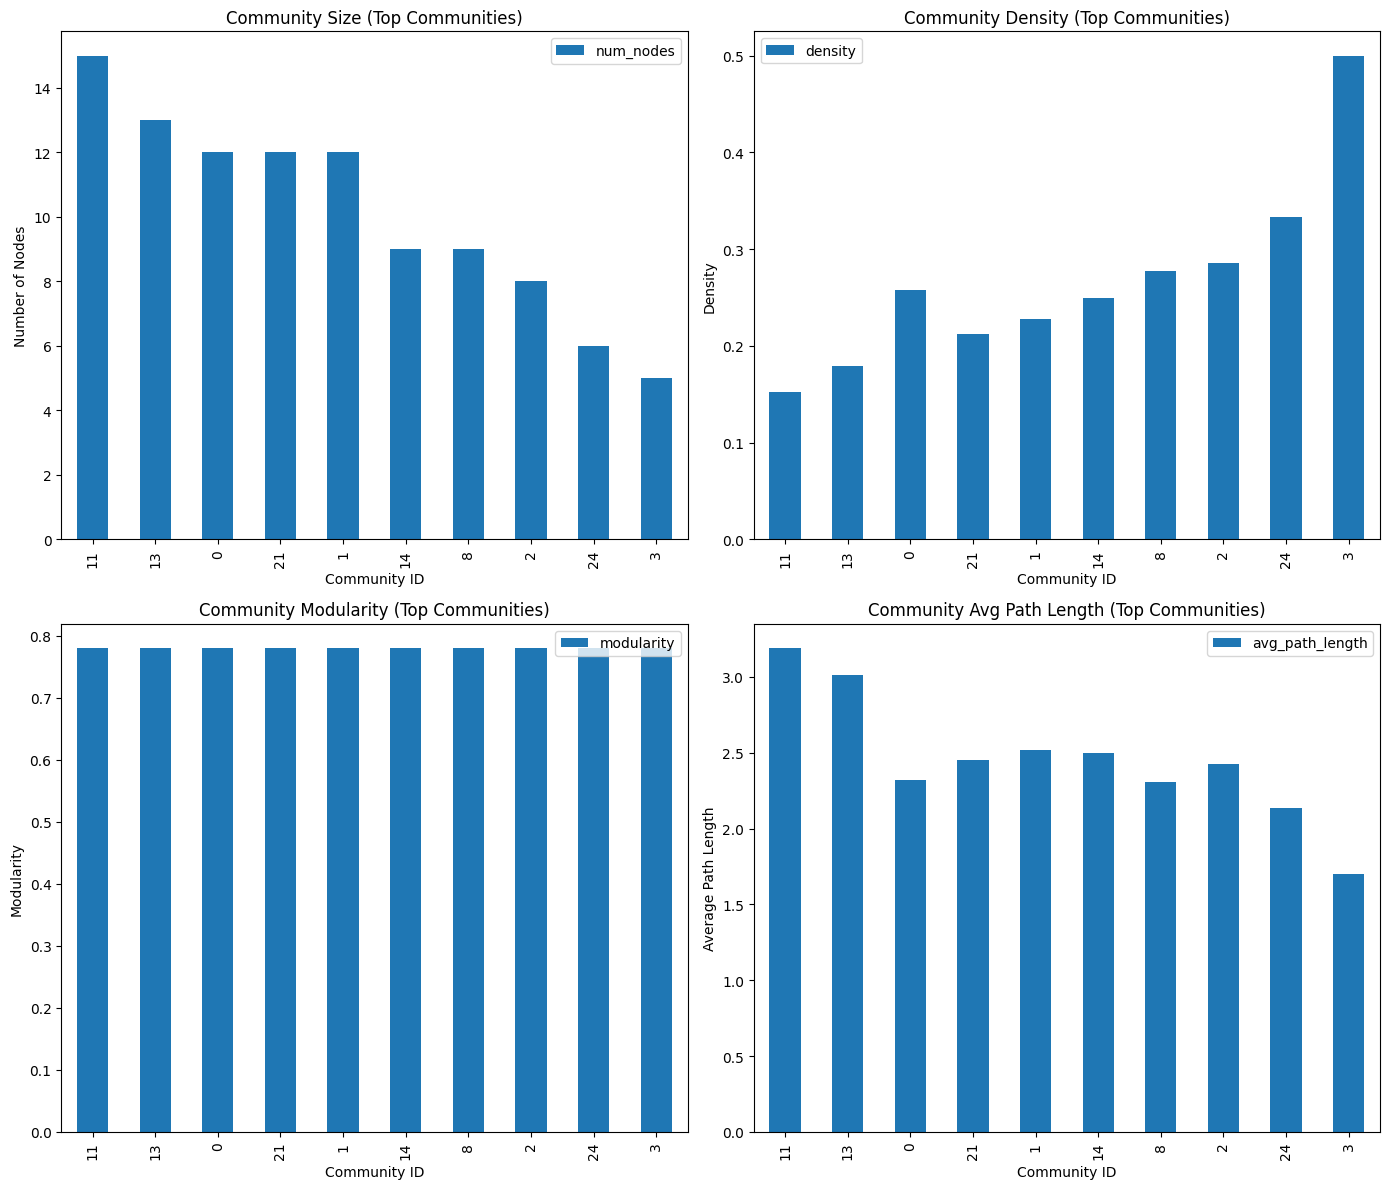

In [55]:

if __name__ == "__main__":
    # Load data
    nodes, layers = load_data()

    # Create graph
    G = create_interlayer_graph(nodes, layers)

    # Detect communities using Louvain algorithm
    partition, communities = detect_communities(G)
 
    # Loop to print out communities with more than 1 node
    print("The non-singleton detected communities are:")
    for comm_id, members in communities.items():
        if len(members) > 1:
            print(f"Community {comm_id}: {members}")

    # Plot communities
    plot_communities(G, partition)

    # Plot heatmap of top N communities
    community_composition_heatmap(partition, nodes, top_n=5)

    # Calculate and display community metrics
    metrics_df = calculate_community_metrics(G, communities)
    # Filter out communities with less than or equal to 1 node
    metrics_df_filtered = metrics_df[metrics_df['num_nodes'] > 1]

    # Print the filtered dataframe
    print("\nCommunity Metrics:\n", metrics_df_filtered.to_string(index=False))

    # Plot metrics
    plot_community_metrics(metrics_df, top_n=10)